In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from scipy.stats import ttest_ind, shapiro, f_oneway,probplot
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV, cross_val_score


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df=pd.read_csv('/content/drive/MyDrive/Ml_projects/medical_insurance.csv')
df.shape

(2772, 7)

In [ ]:
df.columns

Index(['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges'], dtype='object')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2772 entries, 0 to 2771
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       2772 non-null   int64  
 1   sex       2772 non-null   object 
 2   bmi       2772 non-null   float64
 3   children  2772 non-null   int64  
 4   smoker    2772 non-null   object 
 5   region    2772 non-null   object 
 6   charges   2772 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 151.7+ KB


In [ ]:
df.duplicated().sum()

1435

In [ ]:
numerical_col=df.select_dtypes(include=np.number).columns.difference(['charges'])
Q1 = df[numerical_col].quantile(0.25)  # First Quartile
Q3 = df[numerical_col].quantile(0.75)  # Third Quartile
IQR = Q3 - Q1  # Interquartile Range
# Define outlier range
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
# Find the columns with outliers and transform them
outliers_column=[]
for col in numerical_col:
  outliers=((df[col]<lower_bound[col]) | (df[col]>upper_bound[col]))
  if outliers.any():
    outliers_column.append(col)
    # cap the outliers
    df[col]=np.where(df[col]<lower_bound[col],lower_bound[col],df[col])
    df[col]=np.where(df[col]>upper_bound[col],upper_bound[col],df[col])

if outliers_column:
    print(f"Outliers are present in the following columns: {outliers_column}")
    print("Outliers have been transformed by capping them within the valid range.")
else:
    print("No outliers found in the dataset.")

Outliers are present in the following columns: ['bmi']
Outliers have been transformed by capping them within the valid range.


In [ ]:
sns.set_theme(style="darkgrid")
sns.set_context('paper')
plt.figure(figsize=(8,6))

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

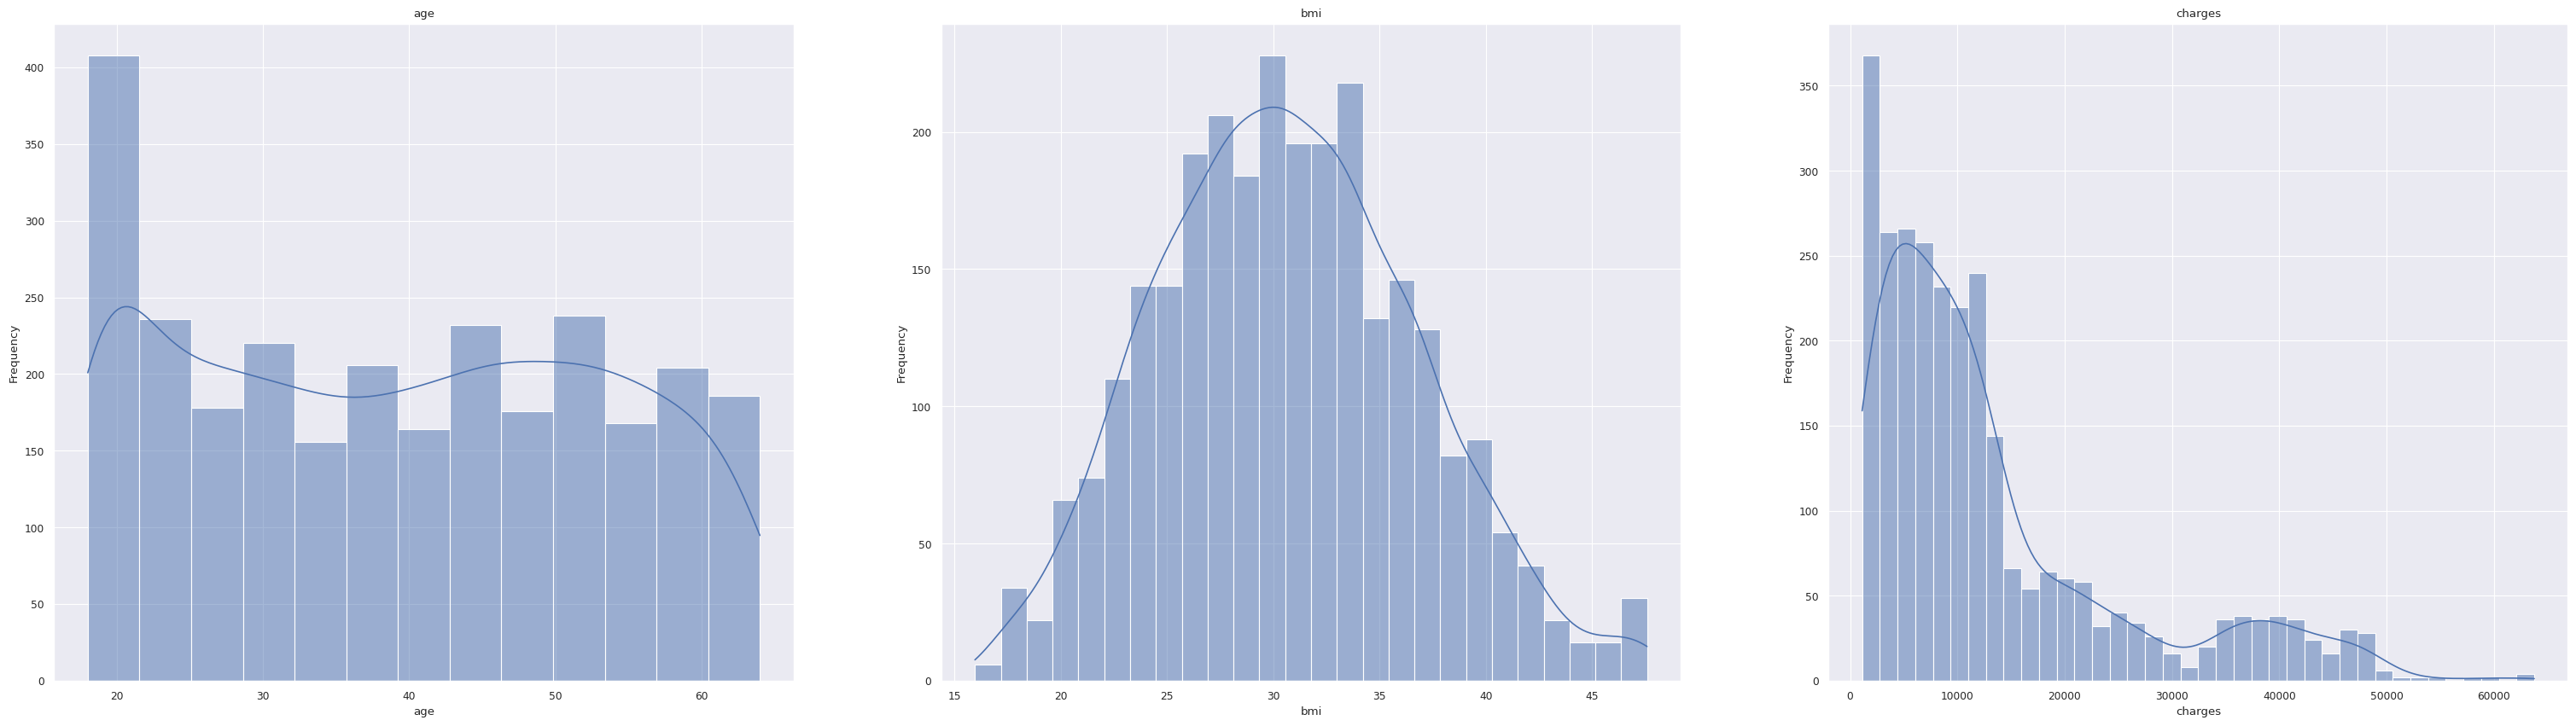

In [ ]:
histplot_columns = ['age', 'bmi', 'charges']
fig, axes = plt.subplots(1, len(histplot_columns), figsize=(38, 10))
# Plot each column
for i, col in enumerate(histplot_columns):
    sns.histplot(df[col], kde=True, ax=axes[i])
    axes[i].set_title(col)
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')

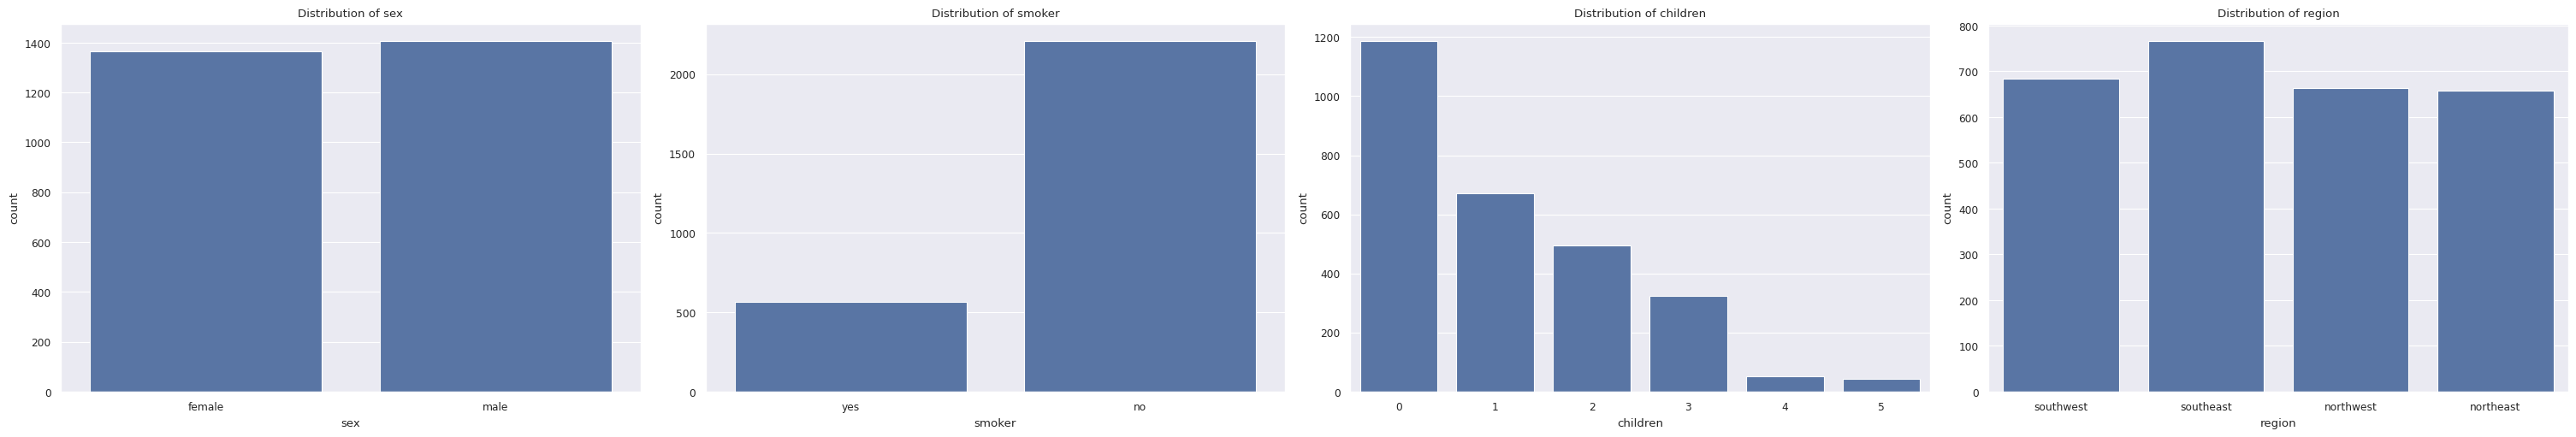

In [ ]:
barplot_cols=[ 'sex','smoker', 'children','region']
fig, axes = plt.subplots(1, len(barplot_cols), figsize=(30, 5), constrained_layout=True)
# Plot each column
for i, col in enumerate(barplot_cols):
    sns.countplot(x=df[col], ax=axes[i])
    axes[i].set_title(f'Distribution of {col}')
plt.show()

In [ ]:
numerical_data=df.select_dtypes(include=['float','int'])
correlation_with_target=numerical_data.corr()['charges'].sort_values(ascending=False)
print(correlation_with_target)

charges     1.000000
age         0.298624
bmi         0.200457
children    0.066442
Name: charges, dtype: float64


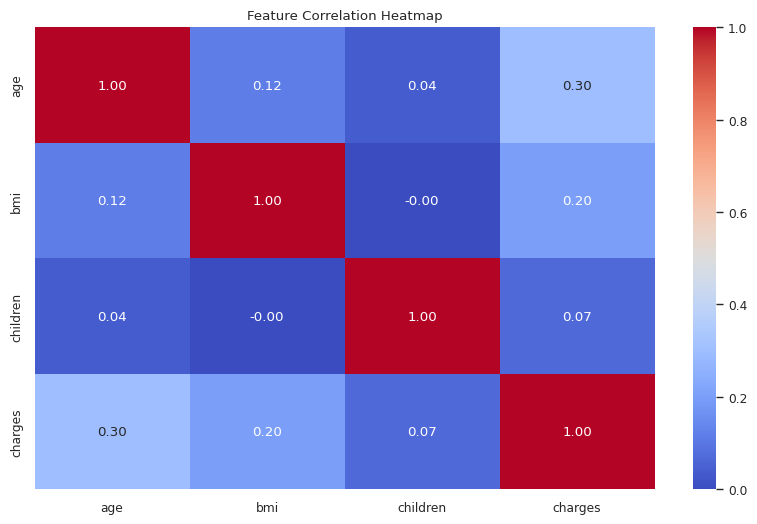

In [ ]:
# Step 4: Bivariate Analysis
plt.figure(figsize=(10, 6))
sns.heatmap(numerical_data.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()

In [ ]:
# step 5 : Hypothesis testing for Smokers and charges
t_stat, p_value=ttest_ind(df[df['smoker']=='yes']['charges'],df[df['smoker']=='no']['charges'],equal_var=True)
print(f"T-Test Results: T-Statistic={t_stat}, P-Value={p_value}")
if p_value<0.05:
  print("Reject H₀: Smoking significantly affects insurance charges.")
else:
  print("Fail to reject H₀: Smoking does not significantly affect insurance charges.")

T-Test Results: T-Statistic=67.53900698901252, P-Value=0.0
Reject H₀: Smoking significantly affects insurance charges.


In [ ]:
# Hypothesis testing for gender and charges
t_stat, p_value=ttest_ind(df[df['sex']=='male']['charges'],df[df['sex']=='female']['charges'],equal_var=True)
print(f"T-Test Results: T-Statistic={t_stat}, P-Value={p_value}")
if p_value<0.05:
  print("Reject H₀: Gender significantly affects insurance charges.")
else:
  print("Fail to reject H₀: Gender does not significantly affect insurance charges.")

T-Test Results: T-Statistic=3.3137003709042956, P-Value=0.0009325439388301053
Reject H₀: Gender significantly affects insurance charges.


In [ ]:
# Hypothesis testing for Region and charges
group_se=df[df['region']=='southeast']['charges']
group_sw=df[df['region']=='southwest']['charges']
group_nw=df[df['region']=='northwest']['charges']
group_ne=df[df['region']=='northeast']['charges']
f_stat, p_value = f_oneway(group_se, group_sw, group_nw, group_ne)

print(f"F-statistic: {f_stat}, P-value: {p_value}")

if p_value < 0.05:
    print("Reject the null hypothesis: There is a significant difference between regions.")
else:
    print("Fail to reject the null hypothesis: No significant difference between regions.")

F-statistic: 6.749357236420865, P-value: 0.00015591629888162578
Reject the null hypothesis: There is a significant difference between regions.


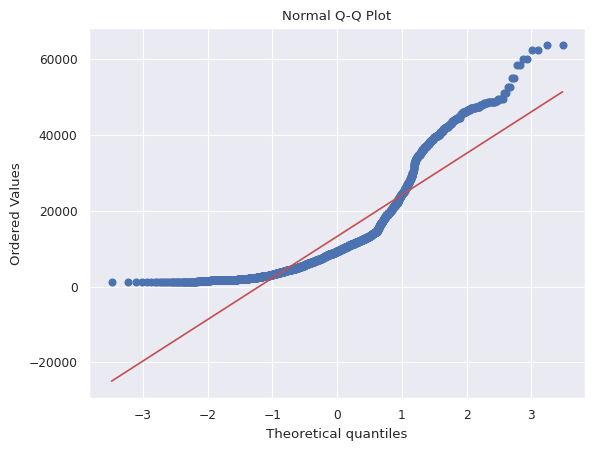

In [ ]:
probplot(df['charges'], dist='norm', plot=plt)
plt.title('Normal Q-Q Plot')
plt.show()

In [ ]:
# Step 6: Normality check
stat, p = shapiro(df['charges'])
print(f"Shapiro-Wilk Test: Statistic={stat}, P-Value={p}")
if p > 0.05:
    print("Data is normally distributed.")
else:
    print("Data is not normally distributed, applying log transformation.")
    df['charges'] = np.log1p(df['charges'])

Shapiro-Wilk Test: Statistic=0.8135250027570576, P-Value=6.127282530110081e-49
Data is not normally distributed, applying log transformation.


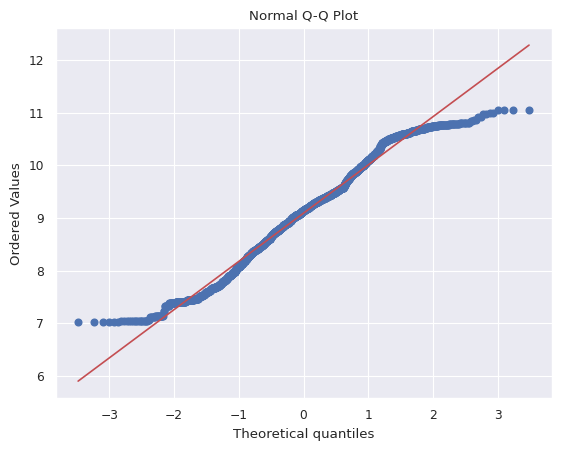

In [ ]:
probplot(df['charges'], dist='norm', plot=plt)
plt.title('Normal Q-Q Plot')
plt.show()

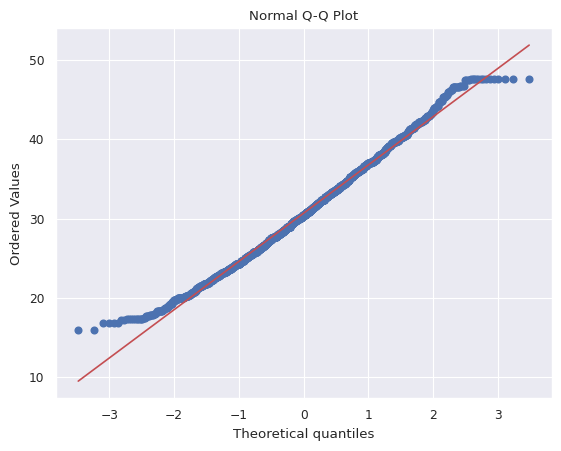

In [ ]:
probplot(df['bmi'], dist='norm', plot=plt)
plt.title('Normal Q-Q Plot')
plt.show()

In [ ]:
stat, p = shapiro(df['bmi'])
print(f"Shapiro-Wilk Test: Statistic={stat}, P-Value={p}")
if p > 0.05:
    print("Data is normally distributed.")
else:
    print("Data is not normally distributed, applying log transformation.")
    df['bmi'] = np.log1p(df['bmi'])

Shapiro-Wilk Test: Statistic=0.9935634934428877, P-Value=1.0289724124718123e-09
Data is not normally distributed, applying log transformation.


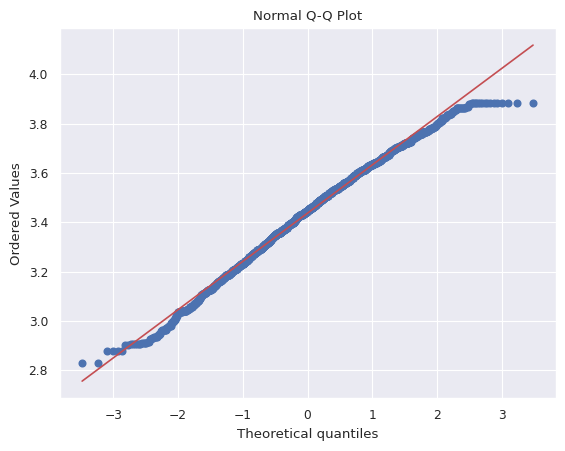

In [ ]:
probplot(df['bmi'], dist='norm', plot=plt)
plt.title('Normal Q-Q Plot')
plt.show()

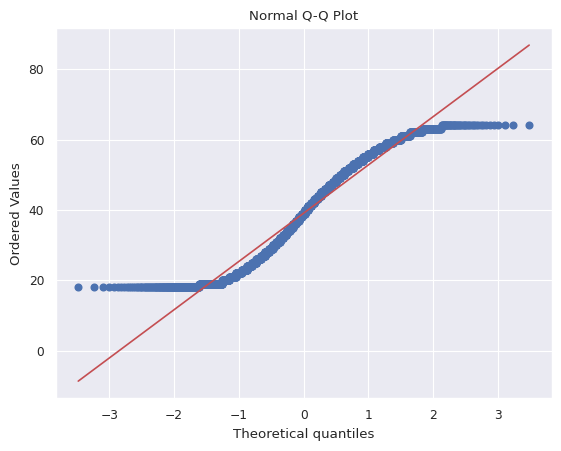

In [ ]:
probplot(df['age'], dist='norm', plot=plt)
plt.title('Normal Q-Q Plot')
plt.show()

In [ ]:
stat, p = shapiro(df['age'])
print(f"Shapiro-Wilk Test: Statistic={stat}, P-Value={p}")
if p > 0.05:
    print("Data is normally distributed.")
else:
    print("Data is not normally distributed, applying log transformation.")
    df['age'] = np.log1p(df['age'])

Shapiro-Wilk Test: Statistic=0.9436160844113513, P-Value=2.6571512608531216e-31
Data is not normally distributed, applying log transformation.


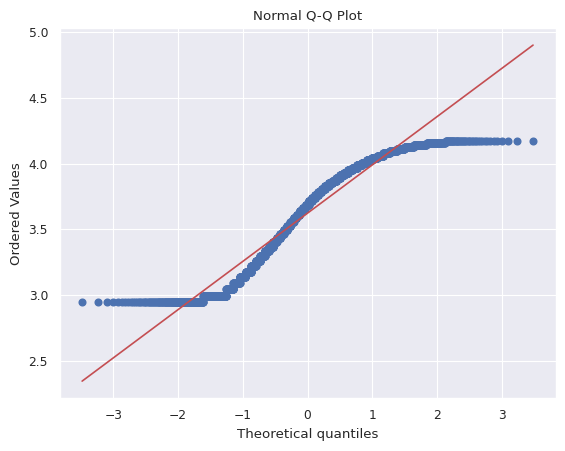

In [ ]:
probplot(df['age'], dist='norm', plot=plt)
plt.title('Normal Q-Q Plot')
plt.show()

In [ ]:
df["sex"] = df["sex"].map({'female': 0, 'male': 1})
df["smoker"] = df["smoker"].map({'yes': 1, 'no': 0})
df["region"] = df["region"].map({'southwest': 0, 'southeast': 1, 'northwest': 2, 'northeast': 3})

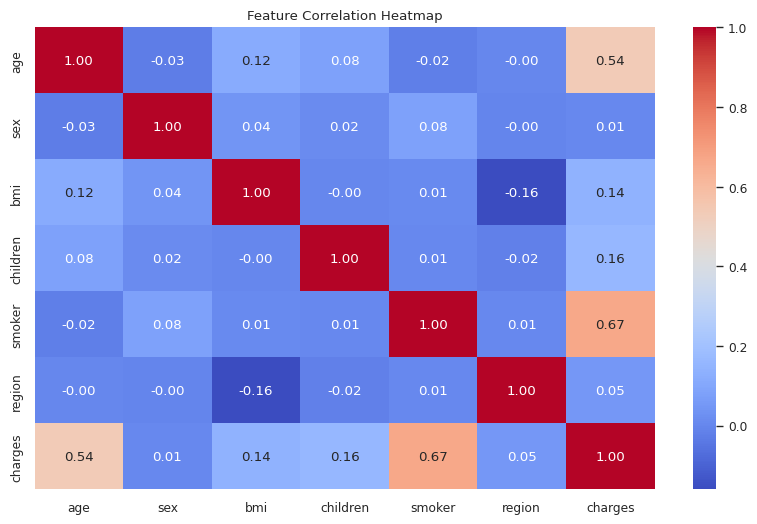

In [ ]:
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()

In [ ]:
X=df.drop(columns=['charges'])
y=df['charges']

In [ ]:
from sklearn.feature_selection import VarianceThreshold, SelectKBest, chi2, mutual_info_regression

In [ ]:
# VarianceThreshold for feature selection (removes features with low variance)
var_thres=VarianceThreshold(threshold=0.05)
var_thres.fit_transform(X)
selected_features_var=X.columns[var_thres.get_support()]
print(selected_features_var)

Index(['age', 'sex', 'children', 'smoker', 'region'], dtype='object')


In [ ]:
# Chi-square test for feature selection
selector = SelectKBest(mutual_info_regression, k=5)
X_chi2 = selector.fit_transform(X, y)
selected_features_chi2 = X.columns[selector.get_support()]
print(selected_features_chi2)

Index(['age', 'sex', 'bmi', 'children', 'region'], dtype='object')


In [ ]:

# Random Forest Feature Importance
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X, y)
feature_importance = pd.DataFrame({'feature': X.columns, 'importance': rf.feature_importances_})
feature_importance = feature_importance.sort_values('importance', ascending=False)
print(feature_importance)

    feature  importance
4    smoker    0.443492
0       age    0.373872
2       bmi    0.106585
3  children    0.043511
5    region    0.021737
1       sex    0.010803


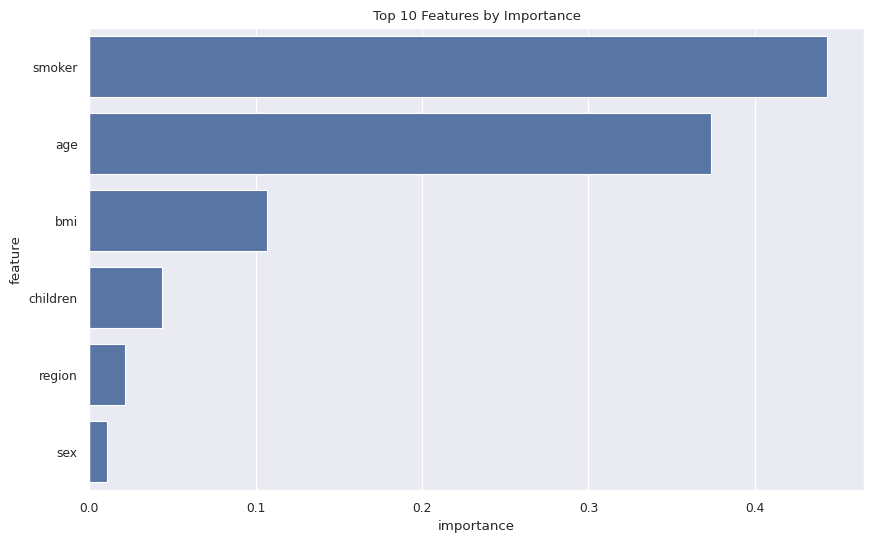

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance.head(10))
plt.title("Top 10 Features by Importance")
plt.show()

In [ ]:
# Print selected features
print("Selected features (Variance Threshold):", selected_features_var)
print()
print("Selected features (Chi-square):", selected_features_chi2)
print()
print("Top 10 features (Random Forest):", feature_importance['feature'].head(10).tolist())


Selected features (Variance Threshold): Index(['age', 'sex', 'children', 'smoker', 'region'], dtype='object')

Selected features (Chi-square): Index(['age', 'sex', 'bmi', 'children', 'region'], dtype='object')

Top 10 features (Random Forest): ['smoker', 'age', 'bmi', 'children', 'region', 'sex']


In [ ]:
# Check for multicollinearity
correlation_matrix = X.corr()
high_correlation = np.where(np.abs(correlation_matrix) > 0.8)
high_correlation = [(correlation_matrix.index[x], correlation_matrix.columns[y]) for x, y in zip(*high_correlation) if x != y and x < y]

In [ ]:
print("Highly correlated features:")
for feat1, feat2 in high_correlation:
    print(f"{feat1} and {feat2}: {correlation_matrix.loc[feat1, feat2]:.2f}")

Highly correlated features:


In [ ]:
numerical_col= df.select_dtypes(include=['int','float']).columns.difference(['charges'])
preprocessor=ColumnTransformer([('Num',StandardScaler(),numerical_col)])

In [ ]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

In [ ]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.pipeline import Pipeline
from sklearn.svm import SVR

In [ ]:
# Define classifiers
regressors = {
    'KNN': KNeighborsRegressor(),
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(),
    'Lasso Regression': Lasso(),
    'ElasticNet Regression': ElasticNet(),
    'Decision Tree': DecisionTreeRegressor(),
    'Random Forest': RandomForestRegressor(),
    'Gradient Boosting': GradientBoostingRegressor(),
    'Adaboost': AdaBoostRegressor(),
    'SVR': SVR()
}

In [ ]:
for name, regressor in regressors.items():
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('regressors', regressor)])

In [ ]:
# Function to evaluate model with predict_proba check
def evaluate_model(pipeline,X_train,y_train,X_test,y_test,X,y):
  pipeline.fit(X_train,y_train)
  y_pred=pipeline.predict(X_test)
  mae=mean_absolute_error(y_test,y_pred)
  mse=mean_squared_error(y_test,y_pred)
  r2=r2_score(y_test,y_pred)
  # Perform cross-validation (scoring with negative MSE for consistency)
  cv_scores = cross_val_score(pipeline, X, y, cv=5, scoring='neg_mean_squared_error')
  cv_rmse = np.sqrt(-cv_scores).mean()
  return{
      'Mean Squared Error': mse,
        'Mean Absolute Error': mae,
        'R² Score': r2,
        'Cross-validation Score (MSE)': -cv_scores.mean()  # Convert negative MSE to positive
  }
# Define hyperparameter grid

param_grids = {

    # Linear Regression (No hyperparameters, but tuning fit_intercept)
    'LinearRegression': {
        'regressor__fit_intercept': [True, False]
    },

    # Ridge Regression (L2 Regularization)
    'Ridge': {
        'regressor__alpha': [0.01, 0.1, 1, 10, 100],
        'regressor__solver': ['auto', 'svd', 'cholesky', 'lsqr']
    },

    # Lasso Regression (L1 Regularization)
    'Lasso': {
        'regressor__alpha': [0.001, 0.01, 0.1, 1, 10],
        'regressor__max_iter': [1000, 5000, 10000]
    },

    # ElasticNet Regression (L1 + L2 Regularization)
    'ElasticNet': {
        'regressor__alpha': [0.01, 0.1, 1, 10],
        'regressor__l1_ratio': [0.1, 0.5, 0.9]
    },

    # K-Nearest Neighbors Regression (Distance-Based)
    'KNeighbors': {
        'regressor__n_neighbors': [3, 5, 10, 15],
        'regressor__weights': ['uniform', 'distance'],
        'regressor__p': [1, 2]
    },

    # Decision Tree Regression (Rule-Based)
    'DecisionTree': {
        'regressor__max_depth': [3, 5, 10, 20, None],
        'regressor__min_samples_split': [2, 5, 10],
        'regressor__min_samples_leaf': [1, 2, 4]
    },

    # Random Forest Regression (Ensemble of Decision Trees)
    'RandomForest': {
        'regressor__n_estimators': [50, 100, 200],
        'regressor__max_depth': [3, 5, 10, None],
        'regressor__min_samples_split': [2, 5, 10],
        'regressor__min_samples_leaf': [1, 2, 4]
    },

    # Gradient Boosting Regression (Boosting Trees)
    'GradientBoosting': {
        'regressor__n_estimators': [100, 200, 300],
        'regressor__learning_rate': [0.01, 0.05, 0.1, 0.2],
        'regressor__max_depth': [3, 5, 10]
    },

    # AdaBoost Regression (Boosting with Weak Learners)
    'AdaBoost': {
        'regressor__n_estimators': [50, 100, 200],
        'regressor__learning_rate': [0.01, 0.05, 0.1, 0.2],
        'regressor__loss': ['linear', 'square', 'exponential']
    },

    # Support Vector Regression (SVR - Kernel-Based)
    'SVR': {
        'regressor__kernel': ['linear', 'poly', 'rbf'],
        'regressor__C': [0.1, 1, 10, 100],
        'regressor__epsilon': [0.01, 0.1, 0.2, 0.5],
        'regressor__gamma': ['scale', 'auto']
    }
}

In [ ]:
# Train and evaluate regression models
results={}
best_params = {}
for name,regressor in regressors.items():
  pipeline=Pipeline(steps=[('preprocessor', preprocessor), ('regressor', regressor)])
  if name in param_grids:
        grid_search = GridSearchCV(pipeline, param_grids[name], cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
        grid_search.fit(X_train, y_train)
        best_pipeline = grid_search.best_estimator_
        best_params[name] = grid_search.best_params_
  else:
        best_pipeline = pipeline.fit(X_train, y_train)

  results[name] = evaluate_model(best_pipeline, X_train, y_train, X_test, y_test, X, y)



In [ ]:
# Print Results
for name, metrics in results.items():
    print(f"\n{name}:")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")

    if name in best_params:
        print(f"\n Best Parameters: {best_params[name]}")



KNN:
Mean Squared Error: 0.1787
Mean Absolute Error: 0.2313
R² Score: 0.8099
Cross-validation Score (MSE): 0.1242

Linear Regression:
Mean Squared Error: 0.2327
Mean Absolute Error: 0.3100
R² Score: 0.7523
Cross-validation Score (MSE): 0.1999

Ridge Regression:
Mean Squared Error: 0.2327
Mean Absolute Error: 0.3101
R² Score: 0.7523
Cross-validation Score (MSE): 0.1999

Lasso Regression:
Mean Squared Error: 0.9477
Mean Absolute Error: 0.7868
R² Score: -0.0086
Cross-validation Score (MSE): 0.8536

ElasticNet Regression:
Mean Squared Error: 0.8639
Mean Absolute Error: 0.7539
R² Score: 0.0805
Cross-validation Score (MSE): 0.7644

Decision Tree:
Mean Squared Error: 0.0725
Mean Absolute Error: 0.0555
R² Score: 0.9228
Cross-validation Score (MSE): 0.0049

Random Forest:
Mean Squared Error: 0.0644
Mean Absolute Error: 0.1080
R² Score: 0.9315
Cross-validation Score (MSE): 0.0252

Gradient Boosting:
Mean Squared Error: 0.1482
Mean Absolute Error: 0.1901
R² Score: 0.8422
Cross-validation Score (

In [ ]:
# Identify the best model
best_model = max(results, key=lambda x: results[x]['Cross-validation Score (MSE)'])
print(f"\nBest model: {best_model}")


Best model: Lasso Regression


In [ ]:
best_model = max(results, key=lambda x: results[x]['Mean Squared Error'])
print(f"\nBest Model: {best_model}")
print(f"Performance: {results[best_model]}")
print(f"Best Hyperparameters: {best_params[name]}")



Best Model: Lasso Regression
Performance: {'Mean Squared Error': 0.9476694804790982, 'Mean Absolute Error': 0.786773749106669, 'R² Score': -0.00859992356548922, 'Cross-validation Score (MSE)': 0.8535727227782356}
Best Hyperparameters: {'regressor__C': 10, 'regressor__epsilon': 0.1, 'regressor__gamma': 'scale', 'regressor__kernel': 'rbf'}


In [ ]:
best_params[name]

{'regressor__C': 10,
 'regressor__epsilon': 0.1,
 'regressor__gamma': 'scale',
 'regressor__kernel': 'rbf'}